In [ ]:
torch.cuda.empty_cache()
gc.collect()

84

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
import os
import json
import struct
from PIL import Image
import gc


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

json_file = "/content/drive/MyDrive/dataset/custom-dataset/transforms_1.json"
dataset_root = "/content/drive/MyDrive/dataset/custom-dataset"
#points3d_path = "/content/drive/MyDrive/dataset/custom-dataset/colmap_output_1/0/points3D.bin"
points3d_path = "/content/drive/MyDrive/dataset/custom-dataset/colmap_output_1 /0/points3D.bin"


In [3]:
def load_data(json_path, root_dir):
  with open(json_path, 'r') as fp:
    meta = json.load(fp)

  imgs = []
  poses = []

  # Target size (downscaled for pure PyTorch speed)
  W_target = 100
  H_target = 178

  print(f"loading images (resizing to {W_target}x{H_target})")

  for frame in tqdm(meta['frames']):
    fname = os.path.join(root_dir, frame['file_path'])
    if not os.path.exists(fname): continue

    img = Image.open(fname).convert('RGB')
    img = img.resize((W_target, H_target), Image.LANCZOS)
    imgs.append(torch.tensor(np.array(img)).float() / 255.)
    poses.append(torch.tensor(frame['transform_matrix']).float())

  camera_angle_x = meta['camera_angle_x']
  focal = 0.5 * W_target / np.tan(0.5 * camera_angle_x)

  return torch.stack(imgs).to(device), torch.stack(poses).to(device), focal, H_target, W_target



In [4]:
# BINARY POINT CLOUD LOADER
def read_points3D_binary(path_to_model_file):
  print(f"Reading COLMAP point cloud from: {path_to_model_file}")
  points3D = []
  colors = []

  if not os.path.exists(path_to_model_file):
    print("points3D.bin not founddd!!!!!!!!!! falling back to random initt")
    return None, None

  with open(path_to_model_file, "rb") as fid:
    num_points = struct.unpack("<Q", fid.read(8))[0]
    print(f"FOUNDD {num_points} points")

    for _ in range(num_points):
      binary_point = fid.read(43) # 43 bytes per point
      # FORMAT: ID(Q), X(d), Y(d), Z(d), R(B), G(B), B(B), Error(d)
      data = struct.unpack("<QdddBBBd", binary_point)

      xyz = np.array(data[1:4])
      rgb = np.array(data[4:7])

      points3D.append(xyz)
      colors.append(rgb)

      # read track length and skip track data (we dont need it)
      track_length = struct.unpack("<Q", fid.read(8))[0]
      fid.read(track_length * 8)

  return np.array(points3D), np.array(colors)

In [5]:
def build_rotation(r):
  norm = torch.sqrt(r[:,0]*r[:,0] + r[:,1]*r[:,1] + r[:,2]*r[:,2] + r[:,3]*r[:,3])
  q = r / norm[:, None]
  R = torch.zeros((q.shape[0], 3, 3), device=device)
  r, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

  R[:, 0, 0] = 1 - 2 * (y*y + z*z)
  R[:, 0, 1] = 2 * (x*y - r*z)
  R[:, 0, 2] = 2 * (x*z + r*y)
  R[:, 1, 0] = 2 * (x*y + r*z)
  R[:, 1, 1] = 1 - 2 * (x*x + z*z)
  R[:, 1, 2] = 2 * (y*z - r*x)
  R[:, 2, 0] = 2 * (x*z - r*y)
  R[:, 2, 1] = 2 * (y*z + r*x)
  R[:, 2, 2] = 1 - 2 * (x*x + y*y)

  return R

def build_convariance_3d(scale, rot):
  S = torch.zeros((scale.shape[0], 3, 3), device=device)
  S[:, 0, 0] = scale[:, 0]
  S[:, 1, 1] = scale[:, 1]
  S[:, 2, 2] = scale[:, 2]
  R = build_rotation(rot)
  M = torch.bmm(R, S)
  Cov3D = torch.bmm(M, M.transpose(1, 2))
  return Cov3D

def project_cov_2d(cov3d, view_matrix, focal, center, H, W):
  # View Matrix (World -> cam)
  W_mat = view_matrix[:3, :3]
  p_cam = torch.matmul(torch.cat([center, torch.ones_like(center[:, :1])], dim=1), torch.inverse(view_matrix).T)[:, :3]

  # Project 3D covariance to Camera Space
  T = torch.matmul(torch.matmul(W_mat, cov3d), W_mat.T)

  # Simple Perspective projection approximation
  z = p_cam[:, 2].clamp(min=0.1)
  scale_factor = (focal / z) ** 2

  cov2d = torch.zeros((cov3d.shape[0], 2, 2), device=device)
  cov2d[:, 0, 0] = T[:, 0, 0] * scale_factor + 0.3
  cov2d[:, 0, 1] = T[:, 0, 1] * scale_factor
  cov2d[:, 1, 0] = T[:, 1, 0] * scale_factor
  cov2d[:, 1, 1] = T[:, 1, 1] * scale_factor + 0.3

  return cov2d, p_cam

In [6]:
class GaussianModel(nn.Module):
  def __init__(self, initial_points=None, initial_colors=None, num_points=2000):
    super().__init__()

    if initial_points is not None:
      print("Initializing with real COLMAP points")
      self.means = nn.Parameter(torch.tensor(initial_points).float().to(device))

      # Initialize colors from COLMAP (converted to 0-1 range)
      # using Inverse Sigmoid so that sigmoid(p) = color
      c_norm = torch.tensor(initial_colors).float().to(device) / 255.0
      self.colors = nn.Parameter(torch.logit(c_norm.clamp(0.01, 0.99)))

      num_points = len(initial_points)

    else:
      print("No points provided, using random initializationnnnnnnnnnnn")
      self.means = nn.Parameter(torch.randn(num_points, 3, device=device) * 4.0 -2.0)
      self.colors = nn.Parameter(torch.rand(num_points, 3, device=device))

    # Inittialize scales (small log scale)
    self.scales = nn.Parameter(torch.full((num_points, 3), -5.0, device=device))
    # Rotation (Identity quaternion)
    self.quats = nn.Parameter(torch.rand(num_points, 4, device=device))
    self.quats.data[:, 0] = 1.0
    self.quats.data[:, 1:] = 0.0

    # opacity (logit space, start slightly visible)
    self.opacities = nn.Parameter(torch.full((num_points, 1), 0.1, device=device))


  def forward(self, view_matrix, H, W, focal):
    scale = torch.exp(self.scales)
    rot = self.quats / self.quats.norm(dim=-1, keepdim=True)
    opacity = torch.sigmoid(self.opacities)
    color = torch.sigmoid(self.colors)

    cov3d = build_convariance_3d(scale, rot)
    cov2d, p_cam = project_cov_2d(cov3d, view_matrix, focal, self.means, H, W)

    cx, cy = W/2, H/2
    screen_x = (p_cam[:, 0] / p_cam[:, 2]) * focal + cx
    screen_y = (p_cam[:, 1] / p_cam[:, 2]) * focal + cy
    means2d = torch.stack([screen_x, screen_y], dim=1)

    return means2d, cov2d, opacity, color, p_cam[:, 2]



In [7]:
def render_gaussian_layer(H, W, means2d, cov2d, opacity, color, depth):
    # 1. Create Grid
    y, x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
    coords = torch.stack([x, y], dim=-1).float()

    # 2. Sort (Back to Front for better blending)
    sorted_idx = torch.argsort(depth)
    means2d = means2d[sorted_idx]
    cov2d = cov2d[sorted_idx]
    opacity = opacity[sorted_idx]
    color = color[sorted_idx]

    # 3. Canvas (White Background instead of Black)
    canvas = torch.ones((H, W, 3), device=device)

    # 4. Filter off-screen points
    mask = (means2d[:,0] > 0) & (means2d[:,0] < W) & (means2d[:,1] > 0) & (means2d[:,1] < H)
    indices = torch.where(mask)[0]

    # 5. RENDER ALL POINTS (No Limit)
    # This will be slow! But it will look correct.
    print(f"Rendering {len(indices)} splats...", end='\r')

    for i in indices:
        mu = means2d[i]
        inv_sigma = torch.inverse(cov2d[i] + torch.eye(2, device=device)*1e-5)

        delta = coords - mu
        dist = (delta[:,:,0]**2 * inv_sigma[0,0] +
                2 * delta[:,:,0]*delta[:,:,1] * inv_sigma[0,1] +
                delta[:,:,1]**2 * inv_sigma[1,1])

        alpha_val = opacity[i] * torch.exp(-0.5 * dist)
        alpha_val = alpha_val[..., None]

        # Soft cutoff
        alpha_mask = (alpha_val > 0.05).float()
        weight = alpha_val * alpha_mask

        # Blend
        canvas = canvas * (1 - weight) + color[i] * weight

    return canvas

loading images (resizing to 100x178)


  0%|          | 0/85 [00:00<?, ?it/s]

Reading COLMAP point cloud from: /content/drive/MyDrive/dataset/custom-dataset/colmap_output_1 /0/points3D.bin
FOUNDD 86050 points
Original Cloud: 86050 points. (Too heavy for Python!)
Downsampled to 8000 points for stability.
Initializing with real COLMAP points
===============STARTING GAUSSIAN SPLATTING TRAINING===================


  0%|          | 0/5000 [00:00<?, ?it/s]

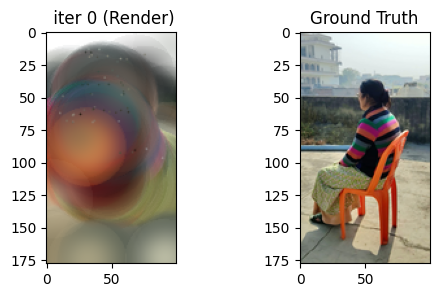

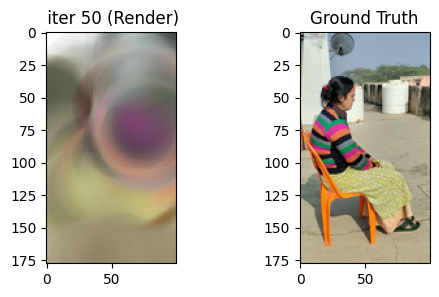

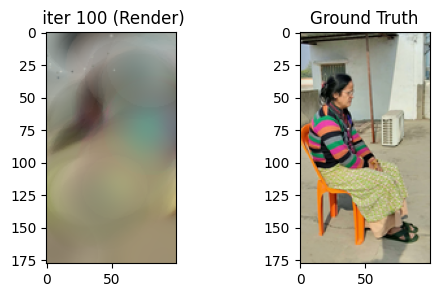

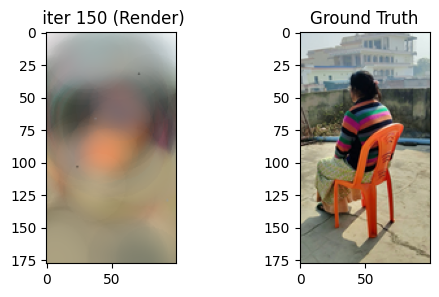

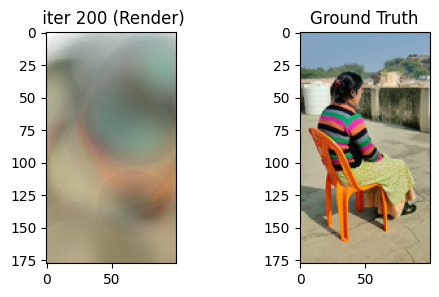

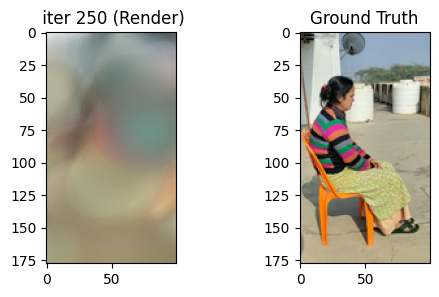

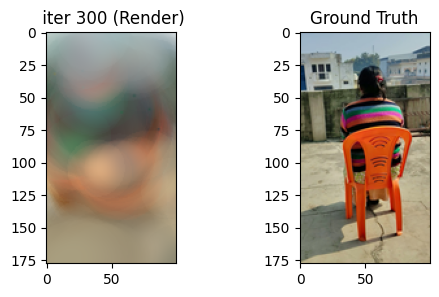

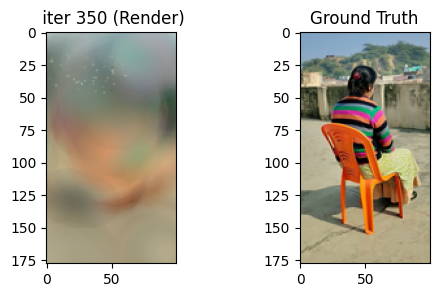

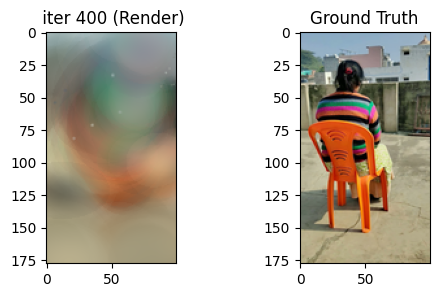

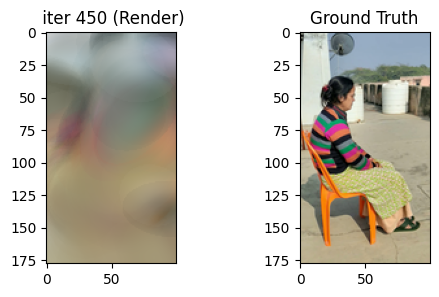

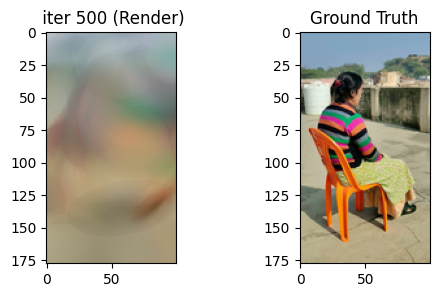

KeyboardInterrupt: 

In [ ]:
# Main Execution

images, poses, focal, H, W = load_data(json_file, dataset_root)

init_pts, init_cols = read_points3D_binary(points3d_path)

# --- INSERT THIS BLOCK TO FIX MEMORY CRASH ---
if init_pts is not None:
    print(f"Original Cloud: {len(init_pts)} points. (Too heavy for Python!)")

    # We will pick 8,000 random points. This is safe for memory.
    target_count = 8000

    if len(init_pts) > target_count:
        indices = np.random.choice(len(init_pts), target_count, replace=False)
        init_pts = init_pts[indices]
        init_cols = init_cols[indices]
        print(f"Downsampled to {len(init_pts)} points for stability.")
    else:
        print("Point count is safe.")

# ---------------------------------------------

model = GaussianModel(initial_points = init_pts, initial_colors = init_cols).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # lower LR for stability

print("===============STARTING GAUSSIAN SPLATTING TRAINING===================")
losses = []

for i in tqdm(range(5000)):
  img_idx = np.random.randint(len(images))
  gt_img = images[img_idx]
  pose = poses[img_idx]

  means2d, cov2d, opacity, color, depth = model(pose, H, W, focal)
  render_img = render_gaussian_layer(H, W, means2d, cov2d, opacity, color, depth)

  loss = F.mse_loss(render_img, gt_img)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if i % 50 == 0:
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(render_img.detach().cpu().numpy()); plt.title(f" iter {i} (Render)")
    plt.subplot(1,2,2); plt.imshow(gt_img.cpu().numpy()); plt.title("Ground Truth")
    plt.show()


print("TRANININGG COMPLETETEEEEE")

In [ ]:
# --- SAVE CHECKPOINT ---
checkpoint_path = "/content/drive/MyDrive/dataset/custom-dataset/gaussian_checkpoint.pth"

print(f"Saving model to {checkpoint_path}...")

torch.save({
    'iteration': i,              # Remembers we are at step 500
    'model_state': model.state_dict(), # Saves means, colors, opacities, etc.
    'optimizer_state': optimizer.state_dict() # Saves the momentum of the training
}, checkpoint_path)

print("Model saved! You can safely close the notebook now.")

Saving model to /content/drive/MyDrive/dataset/custom-dataset/gaussian_checkpoint.pth...
Model saved! You can safely close the notebook now.


In [11]:
# Main Execution

images, poses, focal, H, W = load_data(json_file, dataset_root)

init_pts, init_cols = read_points3D_binary(points3d_path)

# --- INSERT THIS BLOCK TO FIX MEMORY CRASH ---
if init_pts is not None:
    print(f"Original Cloud: {len(init_pts)} points. (Too heavy for Python!)")

    # We will pick 8,000 random points. This is safe for memory.
    target_count = 8000

    if len(init_pts) > target_count:
        indices = np.random.choice(len(init_pts), target_count, replace=False)
        init_pts = init_pts[indices]
        init_cols = init_cols[indices]
        print(f"Downsampled to {len(init_pts)} points for stability.")
    else:
        print("Point count is safe.")

# ---------------------------------------------

# Create the Model Object
model = GaussianModel(initial_points=init_pts, initial_colors=init_cols).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

print(" Model initialized! NOW you can run the Resume script.")

loading images (resizing to 100x178)


  0%|          | 0/85 [00:00<?, ?it/s]

Reading COLMAP point cloud from: /content/drive/MyDrive/dataset/custom-dataset/colmap_output_1 /0/points3D.bin
FOUNDD 86050 points
Original Cloud: 86050 points. (Too heavy for Python!)
Downsampled to 8000 points for stability.
Initializing with real COLMAP points
 Model initialized! NOW you can run the Resume script.


Found checkpoint at /content/drive/MyDrive/dataset/custom-dataset/gaussian_checkpoint.pth. Loading...
Success! Resuming from iteration 535
Continuing Training...


  0%|          | 0/2466 [00:00<?, ?it/s]

Checkpoint updated.


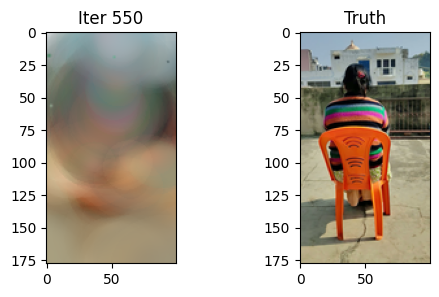

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


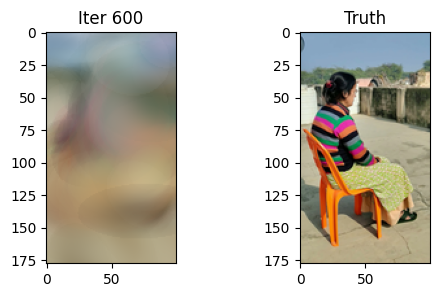

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


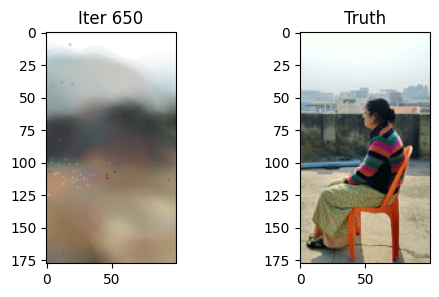

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


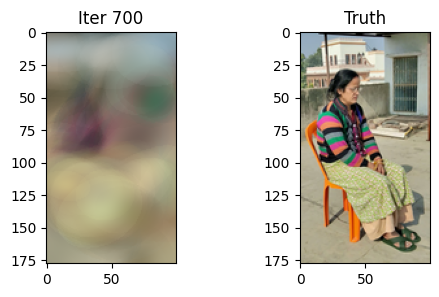

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


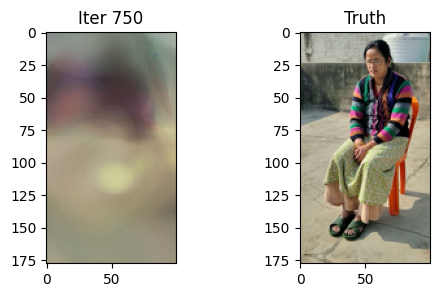

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


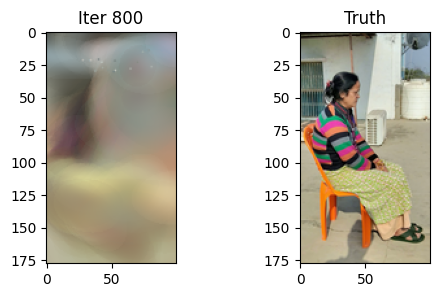

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


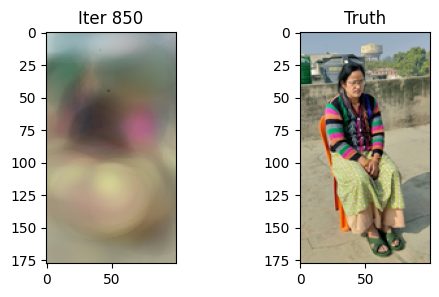

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


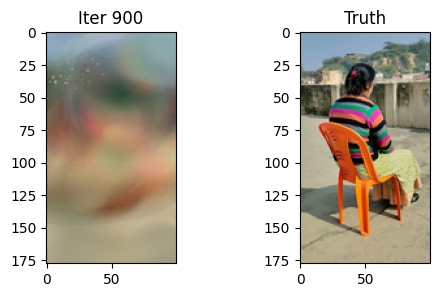

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


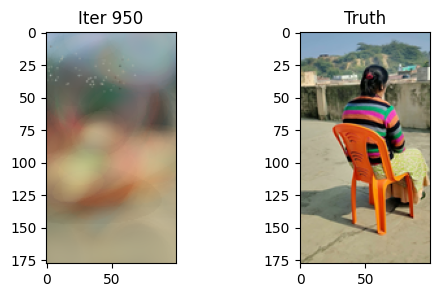

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


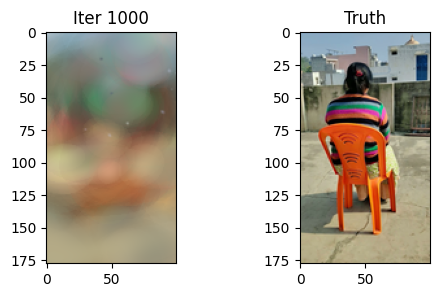

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


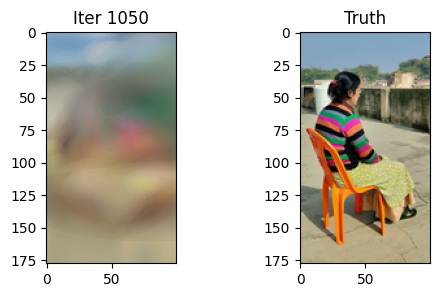

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


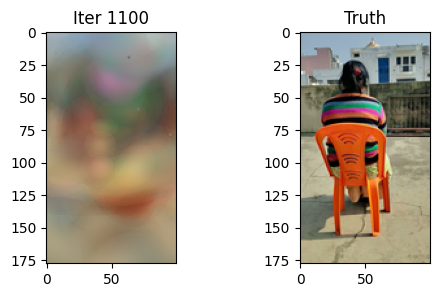

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


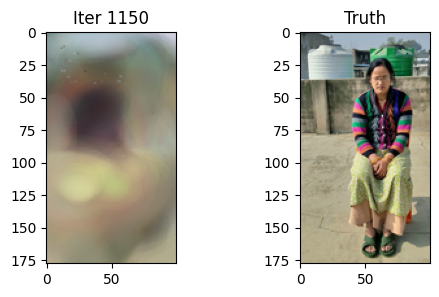

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


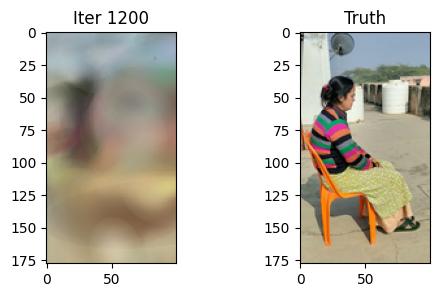

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


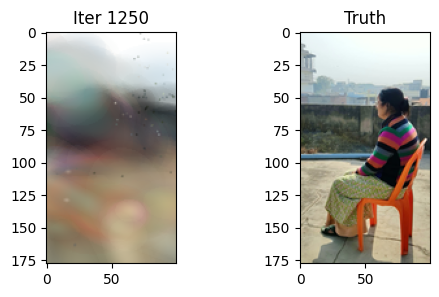

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


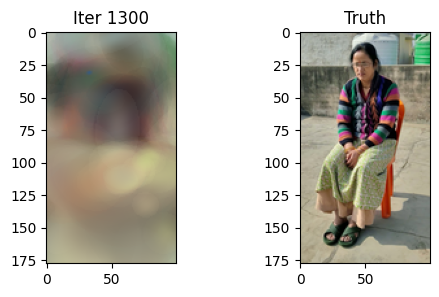

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


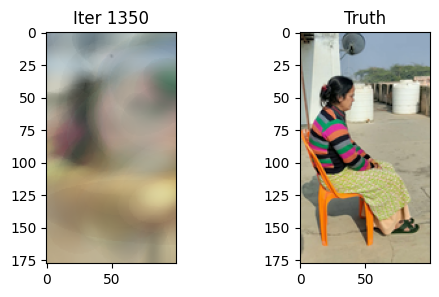

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


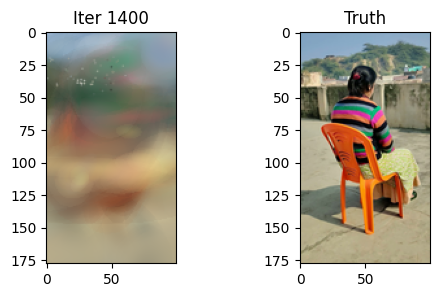

Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.
Checkpoint updated.


KeyboardInterrupt: 

In [14]:
# --- RESUME TRAINING SCRIPT ---
checkpoint_path = "/content/drive/MyDrive/dataset/custom-dataset/gaussian_checkpoint.pth"

# 1. Check if the "shell" exists (The code you just ran should have created 'model')
if 'model' not in locals() or 'optimizer' not in locals():
    print("ERROR: You skipped Step 2! Go run the block you asked about first.")
else:
    # 2. Load the Checkpoint
    if os.path.exists(checkpoint_path):
        print(f"Found checkpoint at {checkpoint_path}. Loading...")
        checkpoint = torch.load(checkpoint_path)

        # Overwrite the fresh model with saved weights
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_iter = checkpoint['iteration'] + 1

        print(f"Success! Resuming from iteration {start_iter}")

        # 3. Resume the Loop
        print("Continuing Training...")

        # Loop from saved step to 3000
        for i in tqdm(range(start_iter, 3001)):
            img_idx = np.random.randint(len(images)) # Note: Ensure 'images' variable matches your loader name
            gt_img = images[img_idx].to(device) # Send to GPU
            pose = poses[img_idx].to(device)

            means2d, cov2d, opacity, color, depth = model(pose, H, W, focal)
            render_img = render_gaussian_layer(H, W, means2d, cov2d, opacity, color, depth)

            loss = F.mse_loss(render_img, gt_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Visualization
            if i % 50 == 0:
                plt.figure(figsize=(6,3))
                plt.subplot(1,2,1); plt.imshow(render_img.detach().cpu().numpy()); plt.title(f"Iter {i}")
                plt.subplot(1,2,2); plt.imshow(gt_img.cpu().numpy()); plt.title("Truth")
                plt.show()

            # Save again every 500 steps
            if i % 10 == 0:
                torch.save({
                    'iteration': i,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict()
                }, checkpoint_path)
                print("Checkpoint updated.")

    else:
        print(f"No checkpoint found at {checkpoint_path}. Did you save it earlier?")